# Réseau de neurones: les bases en numpy


Le but de ce TP est de voir les bases des réseaux de neurones en numpy. Puis de voir comment en pratique on s'en sert avec la librairie Pytorch.

Ce TP sera **à rendre** (voir Discord).
Il y a n points dans ce TP, qui seront divisé pour obtenir une note sur 4.

Ce TP est à faire avec votre **groupe**. Rendez-le avec votre **groupe**.

Si vous avez des **questions**, n'hésitez pas à me les poser sur **Discord**

## Lecture des données, tokenization et BoW

Dans cette section vous devez lire les données (seulement les consensus).

Vous devez construire votre tokenizer (et de préférence le sauvegarder).

Vous devez transformer votre jeu de données (liste de tweets et labels) en liste de vecteurs BoW + liste d'indice des labels.

In [1]:
# Les imports sont préparé ici
# n'enlevez pas les % car il permettent le reload de modules ou l'affichage dans le notebook
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
import numpy as np
import random
import pickle as pkl
import re
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

**Tache 1** 1pt.

Importez/réécrivez le code permettant de lire vos données et les transformer en BoW.

A la fin de cette cellule, vous devrez avoir trois variables d'instanciées :
- X : la liste des vecteurs BoW de vos tweets
- Y : la liste des indices des labels de vos tweets (Y[i] doit contenir le label de X[i])
- Y_one_hot : la liste des labels sous forme one_hot (c'est similaire à un BoW, vous prenez un vecteur de zeros et mettez un 1 à l'indice du label)

In [2]:
# mettez votre code ici
from tokenization import *
from utils import *
from BagOfWord import *

corpus = read_corpus("/home/boulanger/Teaching/2021-2022/EIT5/train_label_final.txt", consensus=True)
tokenizer = WordTokenizer()


labels = {'pos': 0, 'neg': 1, 'neu': 2, 'irr': 3}
Y = [] # Pour les labels il faut des vecteurs en one_hot, par exemple pour irr : [0,0,0,1]
Y_nonehot = []
for i in range(len(corpus)):
    lab = re.match(r"[(].*,(.*),.*[)]", corpus[i][1])
    ap = np.zeros(len(labels.keys()))
    ap[labels[lab[1].lower()]] = 1
    Y_nonehot.append(labels[lab[1].lower()])
    Y.append(ap)


tweets = [c[0] for c in corpus]
for t in tweets:
    tokenizer.add_to_voc(t)

    
tweets_ids = [tokenizer.words_to_ids(t) for t in tweets]


X = [list_to_bow(tw, tokenizer.word2id) for tw in tweets_ids]
X_freq = [list_to_bow_freq(tw, tokenizer.word2id) for tw in tweets_ids]


print(X[0]) # x sont les tweets transformés en vecteurs BoW
print(len(X[0]))
print(X_freq[0])
print(len(X_freq[0]))
print(Y[0]) # y sont les labels transformés en indice

[0 0 0 ... 0 0 0]
11762
[0. 0. 0. ... 0. 0. 0.]
11762
[1. 0. 0. 0.]


## Création du modèle

Nous allons d'abord créer une couche linéaire.
Celle ci comprendra le terme de biais.

Rappel de la formule de la couche linéaire: 
$$
\mathbf{a} = \mathbf{W}\mathbf{x}+ \mathbf{b}
$$

Notons *n_in* et *n_out* respectivement les dimensions de $\mathbf{x}$ et $\mathbf{y}$. 

**Tache 2** 1pt.
- Coder la fonction d'initialisation suivante, l'initialisation est aléatoire Gaussien centrée en 0 avec un écart type 1 / sqrt(n_in). La fonction retourne W et b. 


In [3]:
def init(n_in,n_out):
    W = np.random.normal(size = (n_in, n_out))/np.sqrt(n_in) # TODO
    b = np.random.normal(size = (1, n_out))/np.sqrt(n_in) # TODO
    return W,b

- Testez que votre fonction marche avec les dimensions 5 et 3.


In [4]:
W, b = init(5, 3)
print(W, b)

[[ 0.3025384   0.87938685 -0.27031276]
 [-1.03971274  0.01884593 -0.29904062]
 [ 0.44180641  0.20234681 -0.97588838]
 [ 0.77545345 -0.23175039  0.33929792]
 [-0.2258935  -0.04028016 -0.76886102]] [[ 0.18478747  0.61461136 -0.67209551]]


**Tache 3** 1pt

Implémenter la fonction forward tel que $$a_j = \sum_{i \rightarrow j} W_{ij} x_i + b_j$$ 


où $x_i$ est la valeur du BoW du tweet à l'indice i

$W_{ij}$ est la valeur reliant l'indice $i$ vers la catégorie $j$ (c'est la matrice des poids)

et $b_j$ est le biais associé à la catégorie $j$

Cette fonction dois prendre en entrée un tableau de n vecteur BoW.
Vous aurez besoin du produit scalaire de numpy, aussi connu sous le nom dot, et de la transposition.

In [5]:
def forward(W,b,X):
    """
        Fait la propagation de l'entrée à travers la couche
        :param W: les poids
        :param b: le biais
        :param X: les input (minibatch_size x n_input)
        :type W: ndarray
        :type B: ndarray
        :type X: ndarray
        :return: les valeurs transformés par la couche
        :rtype: ndarray
    """
    return np.dot(X, W) + b #TODO

- Testez votre fonction. Pour cela, faites un batch de taille (2, 5) avec la fonction eye de numpy. La sortie de votre fonction doit être de dimension (2, 3).

In [6]:
Xt = np.eye(2,5)
print(Xt)
Yt = forward(W, b, Xt)
print(Yt)

[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]
[[ 0.48732587  1.49399821 -0.94240827]
 [-0.85492526  0.63345728 -0.97113613]]


**Tache 4** 1pt

Implémenter la fonction softmax stable (on décale les exponentielles grâce à alpha)

$$ \sigma_i = \frac{\exp{(a_i - alpha)}}{\sum_k \exp{(a_k - alpha)}}$$

avec $$ alpha = \max(a_k, 0) $$

In [7]:
def softmax(a):
    """
    Calcule le softmax du batch de sortie de la couche.
    :param a: la sortie de la couche (minibatch x n_out)
    :type a: ndarray
    :return: le softmax
    :rtype: ndarray
    """
    alpha = np.amax(a, initial=0, axis=1, keepdims=True)
    z = np.exp(a - alpha)
    den = np.sum(z, axis=1, keepdims=True)
    return np.divide(z,den)

In [8]:
sm = softmax(Yt)
one_hot = np.eye(2,3)
sm

array([[0.2515184 , 0.688275  , 0.0602066 ],
       [0.15822254, 0.70091391, 0.14086355]])

**Tache 5** 1 pt

Implémenter le calcul du gradient de l'erreur par rapport à la loss à $a_i$:
$$\delta a_i = \sigma_i - 1_{i=l}$$
où $l$ est l'étiquette associée à la donnée courante.

In [9]:
def gradient_out(out, one_hot_batch):
    """
    Calcule le gradient par rapport à la sortie du softmax (on utilise la formule trouvé avec la loss)
    :param out: Valeurs du softmax
    :type out: ndarray
    :param one_hot_batch: la représentation one-hot des labels
    :type one_hot_batch: ndarray
    :return: le gradient
    :rtype: ndarray
    """
    
    return out - one_hot_batch

In [10]:
gradient_out(sm, one_hot)

array([[-0.7484816 ,  0.688275  ,  0.0602066 ],
       [ 0.15822254, -0.29908609,  0.14086355]])

**Tache 6** 1pt

Implémenter la fonction du calcul de gradient par rapport aux paramètres: $$\delta W_{ij} = \delta a_j x_i$$  $$\delta b_{j} = \delta a_j$$  (moyenne sur le batch)

où $\delta W_{ij}$ est la composante du gradient associée à l'arête reliant les unités $i$ et $j$, 

$\delta b_{j}$ est la composante du gradient associée au bias de l'unité $j$, 

$\delta a_j$ est le gradient de l'erreur par rapport à l'unité $j$

In [11]:
def gradient(derror, X, batch_size):
    """
        Calcule le gradient des paramètres
        :param derror: le gradient de sortie
        :param X: les entrées (minibatch_size x n_input)
        :param minibatch_size: la taille du minibatch
        :type derror: ndarray
        :type minibatch: ndarray
        :type minibatch_size: unsigned
        :return: le gradient des paramètres
        :rtype: ndarray, ndarray
    """
    d_w = np.dot(np.transpose(X), derror)/batch_size
    d_b = np.sum(derror, axis=0, keepdims=True)/batch_size
        
    return d_w, d_b

**Tache 7** 1pt 

Implémenter la fonction de mise à jour des paramètres $$\theta = \theta - \eta \delta \theta$$ où $\theta$ est un paramètre du modèle et $\delta \theta$ la composante du gradient associée à $\theta$.

In [12]:
def update(eta, W, b, grad_w, grad_b):
    """
        Mise à jour des paramètres
        :param eta: la step-size
        :param W: les poids
        :param b: le bias
        :param grad_w: le gradient des poids
        :param grad_b: le gradient du biais
        :type eta: float
        :type W: ndarray
        :type b: ndarray
        :type grad_w: ndarray
        :type grad_b: ndarray
        :return: les paramères mis à jour
        :rtype: ndarray, ndarray
    """
    return W - eta*grad_w , b - eta*grad_b

## Algorithme d'apprentissage 

On a tout ce qu'il faut pour mettre en oeuvre l'apprentissage d'un modèle simple. Le modèle est simplement une couche neuronale de sortie, sans couche cachée. 

L'algorithme se déroule en 2 temps, tout d'abord la préparation: 
- init. du modèle
- préparation des données et des variables permettant de stocker l'historique d'apprentissage
- init. des paramètres de la SGD
- définir le nombre d'époque comme une variable

Puis vient la boucle d'apprentissage qui pour chaque époque effectue pour chaque exemple d'apprentissage : 
- inférence du modèle sur l'exemple d'apprentissage 
- calcul de la contribution de l'exemple à la  fonction objectif, et également au taux d'erreur de classification
- Calcul du gradient de sortie
- Mise à jour du modèle

**Tache 8** 1pt

Calculer la log loss

In [13]:
def log_loss(y, one_hot_batch):
    """
    Calcul de la loss
    :param y: la sortie du softmax
    :type y: ndarray
    :param one_hot_batch: les labels en one_hot
    :type one_hot_batch: ndarray
    """
    return -np.sum(np.log(y) * one_hot_batch) / one_hot_batch.shape[0]

In [14]:
log_loss(sm, one_hot)

0.8678046735018387

In [15]:
a = [1, 2]
b = [3, 4]
c = zip(a, b)
list(zip(*c))

[(1, 2), (3, 4)]

**Tache 9** 2pt

Programmez la fonction d'entrainement

In [16]:
def train(W, b, train_X, train_Y, train_Y_onehot, valid_X, valid_Y, valid_Y_onehot, batch_size=64, epochs=100, eta_0=0.01, eta_dec=0.2):
    
    rand = random.Random()
    rand.seed(a=1)
    
    losses = []
    
    f1_batch = []
    f1_valid = []
    
    Ws, bs = [W], [b]
    
    iteration_counter = 0
    for e in range(epochs):
        print(f"epochs : {e}")
        
        z = list(zip(train_X, train_Y, train_Y_onehot))
        rand.shuffle(z)
        
        unzip = list(zip(*z))
        train_X, train_Y, train_Y_onehot = list(unzip[0]), list(unzip[1]), list(unzip[2])
        
        for i in range(0, len(train_X), batch_size):            
            batch_x = train_X[i: min(i + batch_size, len(train_X))]
            batch_y = train_Y[i: min(i + batch_size, len(train_Y))]
            batch_y_onehot = train_Y_onehot[i: min(i + batch_size, len(train_Y_onehot))]
            
            preds = forward(W, b, batch_x)
            #print(preds.shape)
            
            preds = softmax(forward(W, b, batch_x))
            
            f1_batch.append(f1_score(np.array(batch_y, dtype=int), np.argmax(preds, axis=1), average='micro',
                            labels=[i for i in range(4)]))
            
            losses.append(log_loss(preds, np.array(batch_y_onehot)))
            #print(losses[-1])
            
            grad_w, grad_b = gradient(gradient_out(preds, batch_y_onehot), batch_x, batch_size)
            
            eta = eta_0 / (1 + eta_dec * iteration_counter)
            W, b = update(eta, W, b, grad_w, grad_b)
            Ws.append(W)
            bs.append(b)
            
            iteration_counter += 1
                        

        preds_valid = softmax(forward(W, b, np.array(valid_X)))
        
        f1_valid.append(f1_score(np.array(valid_Y, dtype=int), np.argmax(preds_valid, axis=1), average='micro',
                            labels=[i for i in range(4)]))
            
    return Ws, bs, f1_batch, f1_valid, losses            
            

In [17]:
train_X = X[:1500]
train_Y = Y[:1500]
train_Y_nhot = Y_nonehot[:1500]

valid_X = X[1500:1800]
valid_Y = Y[1500:1800]
valid_Y_nhot = Y_nonehot[1500:1800]

test_X = X[1800:]
test_Y = Y[1800:]
test_Y_nhot = Y_nonehot[1800:]

In [18]:
print(train_X[10])
print(train_Y[10])
print(train_Y_nhot[10])

[0 0 0 ... 0 0 0]
[0. 0. 0. 1.]
3


In [19]:
W, b = init(len(X[0]), 4)
Ws, bs, f1_batch, f1_valid,losses = train(W, b, train_X, train_Y_nhot, train_Y, valid_X, valid_Y_nhot, valid_Y, eta_0=0.01, eta_dec=0.001, epochs=100)

epochs : 0
epochs : 1
epochs : 2
epochs : 3
epochs : 4
epochs : 5
epochs : 6
epochs : 7
epochs : 8
epochs : 9
epochs : 10
epochs : 11
epochs : 12
epochs : 13
epochs : 14
epochs : 15
epochs : 16
epochs : 17
epochs : 18
epochs : 19
epochs : 20
epochs : 21
epochs : 22
epochs : 23
epochs : 24
epochs : 25
epochs : 26
epochs : 27
epochs : 28
epochs : 29
epochs : 30
epochs : 31
epochs : 32
epochs : 33
epochs : 34
epochs : 35
epochs : 36
epochs : 37
epochs : 38
epochs : 39
epochs : 40
epochs : 41
epochs : 42
epochs : 43
epochs : 44
epochs : 45
epochs : 46
epochs : 47
epochs : 48
epochs : 49
epochs : 50
epochs : 51
epochs : 52
epochs : 53
epochs : 54
epochs : 55
epochs : 56
epochs : 57
epochs : 58
epochs : 59
epochs : 60
epochs : 61
epochs : 62
epochs : 63
epochs : 64
epochs : 65
epochs : 66
epochs : 67
epochs : 68
epochs : 69
epochs : 70
epochs : 71
epochs : 72
epochs : 73
epochs : 74
epochs : 75
epochs : 76
epochs : 77
epochs : 78
epochs : 79
epochs : 80
epochs : 81
epochs : 82
epochs : 83
ep

**Tache 10** 1 pt

Affichez les courbes de loss et de f1.

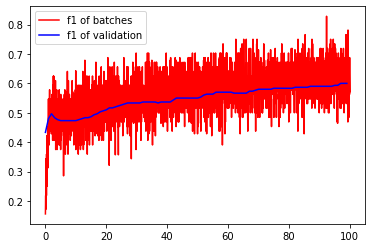

In [20]:
plt.plot([i/(len(f1_batch)/len(f1_valid)) for i in range(len(f1_batch))],f1_batch, color='red', label='f1 of batches')
plt.plot([i for i in range(len(f1_valid))], f1_valid, color='blue', label='f1 of validation')
plt.legend(loc='best')
#plt.plot(np.linspace(0, len(error_test), 10), error_valid, color='blue')
plt.show()
#print(np.sum(error_valid[-100:])/100)

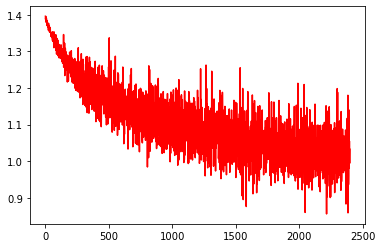

In [21]:
plt.plot(losses, color='red')
#plt.plot(loss_valid, color='blue')
plt.show()

# Partie 2 :  PyTorch

Le but de cette section est de répliquer ce que vous avez fait à la main grâce à une librairie spécialisée.

Cette librairie est Pytorch.

Dans cette librairie vous retrouverez la gestion des poids sous forme de couches dans le sous-module nn.
La gestion du gradient est quasiment automatique.

Le jeu de données sera toujours les vecteurs BoW obtenus.

In [22]:
train_X = X[:1500]
train_Y = Y[:1500]
train_Y_nhot = Y_nonehot[:1500]

valid_X = X[1500:]
valid_Y = Y[1500:]
valid_Y_nhot = Y_nonehot[1500:]


In [23]:
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from sklearn.metrics import f1_score

#device = 'cuda' if T.cuda.is_available() else 'cpu'

**Tache 11** 3 pt

Implémentez le même modèle que précédemment.

Utilisez les couches Linear et LogSoftmax (les probabilités sont souvent des logs probabilités).
Cherchez dans la documentation de torch.nn pour les couches.

In [24]:
class Model(nn.Module): # pour faire un modèle dans pytorch il faut instancier la classe nn.Module
    def __init__(self, in_dim, out_dim):
        super(Model, self).__init__()
        self.linear1 = nn.Linear(in_dim, out_dim) # Ici se trouve la couche Wx + b
        self.softmax = nn.LogSoftmax(dim=1) # Pour pytorch, la plupars des fonction fonctionne avec des logarithmes
        
        
    def forward(self, inputs):
        # Quelque soit le modèle, il vous faut une fonction forward
        # Pour calculer la sortie d'une couche : y = couche(x) avec x un tensor
        y = self.linear1(inputs)
        preds = self.softmax(y)
        return preds    

**Tache 12** 2pt

Complétez la boucle d'entraînement.

In [25]:
def collate(batch):
    transposed_data = list(zip(*batch))
    return T.stack(transposed_data[0], 0), T.stack(transposed_data[1], 0)

def train(train_X, train_Y, valid_X, valid_Y, epochs=100, batch_size=64, lr = 1e-3):
    
    model = Model(len(train_X[0]), 4)
    
    opti = T.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.NLLLoss() # Pour calculer la crossentropy, il faut calculer la NLLL après un logsofmax
    
    
    ## Transformation des données pour l'entraînement
    #trn_X = [T.tensor(x, dtype=T.long) for x in train_X]
    #trn_Y = [T.tensor(y, dtype=T.long) for y in train_Y]
    
    #vld_X = [T.tensor(x, dtype=T.long) for x in valid_X]
    #vld_Y = [T.tensor(y, dtype=T.long) for y in valid_Y]
    
    trn_X = T.tensor(train_X, dtype=T.float)
    trn_Y = T.tensor(train_Y, dtype=T.long)
    
    vld_X = T.tensor(valid_X, dtype=T.float)
    vld_Y = T.tensor(valid_Y, dtype=T.long)
    
    train_set = data.TensorDataset(trn_X, trn_Y)
    valid_set = data.TensorDataset(vld_X, vld_Y)
    
    
    ## Creation des loaders
    train_sampler = data.BatchSampler(data.RandomSampler(range(len(train_X))), batch_size, False)
    valid_sampler = data.BatchSampler(data.SequentialSampler(range(len(valid_X))), len(valid_X), False)
    
    train_loader = data.DataLoader(train_set, batch_sampler=train_sampler, collate_fn=collate)
    valid_loader = data.DataLoader(valid_set, batch_sampler=valid_sampler, collate_fn=collate)
    
    
    losses = []
    f1_valid = []
    
    for e in range(epochs):
        
        model.train() #passe votre modele en phase d'entrainement 
        
        for batch_ndx, (trn_x, trn_y) in enumerate(train_loader):
            opti.zero_grad()
            
            preds = model(trn_x)
            loss = criterion(preds, trn_y)
            losses.append(loss.item())
            loss.backward()
            opti.step()
            
        opti.zero_grad()
        model.eval()
        
        for batch_ndx, (vld_x, vld_y) in enumerate(valid_loader):
            
            preds_val = model(vld_x)
            preds = T.argmax(preds_val, dim=1)
            f1_valid.append(f1_score(vld_y.to('cpu').numpy(), preds.to('cpu').numpy(), average='micro',
                            labels=[i for i in range(4)]))
        print(f"F1 {e}/{epochs}: {f1_valid[-1]}")
    
    return model, losses, f1_valid
        

In [26]:
model, losses, f1_valid = train(train_X, train_Y_nhot, valid_X, valid_Y_nhot, epochs=200, lr=1e-4)

F1 0/200: 0.39600665557404324
F1 1/200: 0.4908485856905158
F1 2/200: 0.5657237936772047
F1 3/200: 0.5956738768718802
F1 4/200: 0.6039933444259568
F1 5/200: 0.6089850249584027
F1 6/200: 0.6139767054908486
F1 7/200: 0.6139767054908486
F1 8/200: 0.6123128119800333
F1 9/200: 0.610648918469218
F1 10/200: 0.6156405990016639
F1 11/200: 0.6173044925124792
F1 12/200: 0.6173044925124792
F1 13/200: 0.6139767054908486
F1 14/200: 0.6139767054908486
F1 15/200: 0.6156405990016639
F1 16/200: 0.6173044925124792
F1 17/200: 0.6189683860232945
F1 18/200: 0.6173044925124792
F1 19/200: 0.6139767054908486
F1 20/200: 0.6139767054908486
F1 21/200: 0.6156405990016639
F1 22/200: 0.6156405990016639
F1 23/200: 0.6139767054908486
F1 24/200: 0.6123128119800333
F1 25/200: 0.6123128119800333
F1 26/200: 0.6123128119800333
F1 27/200: 0.610648918469218
F1 28/200: 0.610648918469218
F1 29/200: 0.610648918469218
F1 30/200: 0.6123128119800333
F1 31/200: 0.6123128119800333
F1 32/200: 0.610648918469218
F1 33/200: 0.61231281198

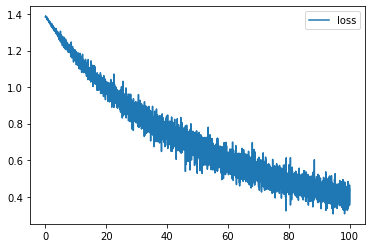

In [27]:
plt.plot([x/(len(losses)/100) for x in range(len(losses))],losses, label="loss")
plt.legend(loc='best')
plt.show()

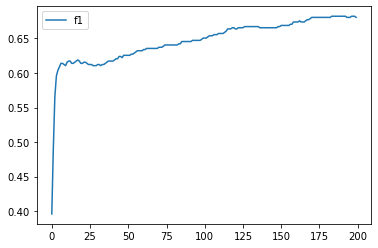

In [28]:
plt.plot(f1_valid, label='f1')
plt.legend(loc='best')
plt.show()

C'est super! Vous avez fini. N'hésitez pas à utiliser ce modèle comme base pour votre projet.